In [37]:
import os
import json
from glob import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

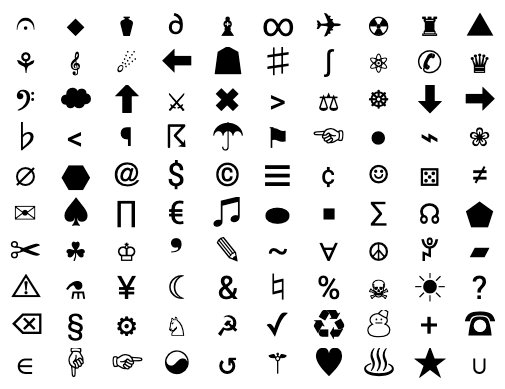

In [6]:
# plot all imgs
fig, axes = plt.subplots(10, 10)
for img, ax in zip(imgs, axes.ravel()):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

In [84]:
# read the json
basepath = '/Users/ic0523/Documents/projects/misc/vlm-binding'
json_paths = sorted(glob(os.path.join(basepath, 'data', 'clevr', 'scenes', '*.json')))
img_paths = sorted(glob(os.path.join(basepath, 'data', 'clevr', 'images', '*.png')))
img_ids = [re.split(r'_|\.', path)[2] for path in img_paths]
json_paths = [path for path in json_paths if re.split(r'_|\.', path)[2] in img_ids] # filter out json files that do not have corresponding images

# Load in the task relevant metadata for the CLEVR dataset
results = pd.DataFrame(np.zeros((len(json_paths), 5)), columns=['path', 'n_objects', 'properties', 'response', 'answer'], dtype=object)
for i, json_path in enumerate(json_paths):
    with open(json_path, 'r') as f:
        scene = json.load(f)
        results.loc[i, 'path'] = os.path.join('data', 'clevr', 'images', scene['image_filename'])
        results.loc[i, 'n_objects'] = len(scene['objects'])
        results.loc[i, 'properties'] = [{'shape': object['shape'], 'color': object['color']} for object in scene['objects']]

In [85]:
test = results[results['n_objects'] == 6].sample(20)
test.to_csv(os.path.join(basepath, 'output', 'counting_results.csv'), index=False)

In [235]:
test = pd.read_csv(os.path.join(basepath, 'output', 'counting_results_clevr_N=8.csv'))
test = test[~test.answer.isna()]
test = test[test.answer!=-1]
test['correct'] = test.answer == test.n_objects
test['correct'].mean()

0.3

(0.0, 1.1)

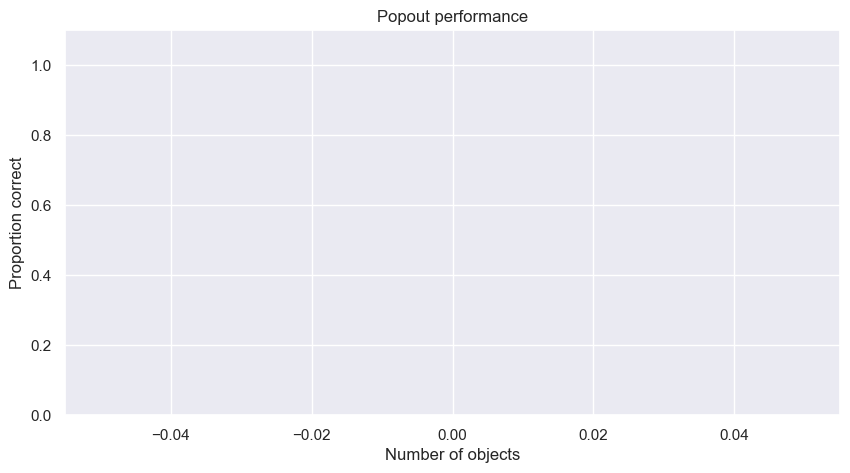

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

test = pd.read_csv(os.path.join(basepath, 'output', 'popout_results.csv'))
test = test[~test.answer.isna()]
test = test[test.answer!="-1"]
test['correct'] = test.answer == test.popout     

# plot error rates with SEM error bars
plt.figure(figsize=(10, 5))
sns.lineplot(x='n_shapes', y='correct', data=test, errorbar='se')
plt.xlabel('Number of objects')
plt.ylabel('Proportion correct')
plt.title('Popout performance')
plt.ylim(0,1.1)

(0.0, 1.0)

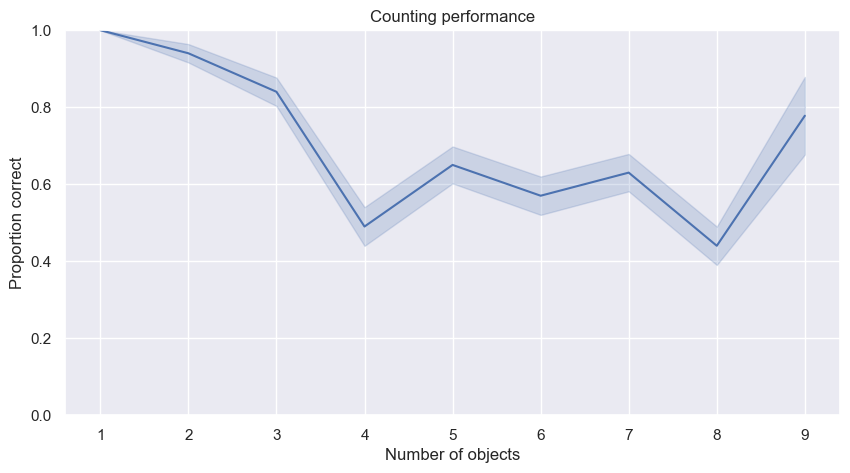

In [300]:
test = pd.read_csv(os.path.join(basepath, 'output', 'counting_results.csv'))
test = test[~test.answer.isna()]
test = test[test.answer!="-1"]
test['correct'] = test.answer == test.n_shapes     
# plot error rates with SEM error bars
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x='n_shapes', y='correct', data=test, errorbar='se')
plt.xlabel('Number of objects')
plt.ylabel('Proportion correct')
plt.title('Counting performance')
plt.ylim(0,1)

(0.0, 1.0)

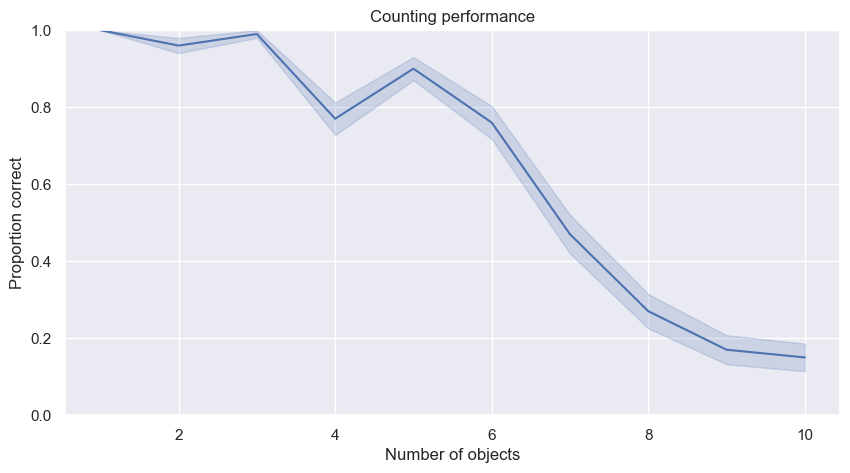

In [262]:
test = pd.read_csv(os.path.join(basepath, 'output', 'counting_results_RANDOM.csv'))
test = test[~test.answer.isna()]
test = test[test.answer!="-1"]
test['correct'] = test.answer == test.n_shapes     
# plot error rates with SEM error bars
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x='n_shapes', y='correct', data=test, errorbar='se')
plt.xlabel('Number of objects')
plt.ylabel('Proportion correct')
plt.title('Counting performance')
plt.ylim(0,1)

In [9]:
import os 


test = pd.read_csv('/Users/ic0523/Documents/projects/misc/vlm-binding/data/binding_balanced/metadata.csv')
test['nFeatures'] = test['n_shapes'] + test['n_colors']
test[test.n_objects==8].nFeatures.value_counts() #.values.sum()

nFeatures
8     105
10    105
9     104
4     102
7     102
11    102
14    102
2     100
3     100
5     100
6     100
12    100
13    100
15    100
16    100
Name: count, dtype: int64

In [1]:
import ast
import pandas as pd
import numpy as np

test = pd.read_csv('output/binding.csv')
test = test[~test.answer.isna()]
test['parsed_response'] = test.answer.apply(lambda x: ast.literal_eval(x))
test['features'] = test.features.apply(lambda x: ast.literal_eval(x))

In [46]:
def compare_arrays(row):
    ground_truth = np.array([obj['shape']+obj['color'] for obj in row.features])
    participant = np.array([obj['shape']+obj['color'] for obj in row.parsed_response])
    # Combine both arrays to get all unique elements
    all_elements = np.concatenate((ground_truth, participant))
    unique_elements = np.unique(all_elements)
    # Create a dictionary to map each unique element to a unique integer
    element_to_int = {element: i for i, element in enumerate(unique_elements)}
    # Convert the arrays to integer arrays using the mapping
    ground_truth = np.array([element_to_int[element] for element in ground_truth])
    participant = np.array([element_to_int[element] for element in participant])
    # Count occurrences of each element in both arrays
    ground_truth_counts = np.bincount(ground_truth, minlength=len(unique_elements))
    participant_counts = np.bincount(participant, minlength=len(unique_elements))
    # Calculate the absolute difference in counts for each element
    differences = np.abs(ground_truth_counts - participant_counts)
    # Sum up the differences to get the total number of differences
    num_differences = np.sum(differences)
    return num_differences

In [47]:
for i, row in test.iterrows():
    test.loc[i, 'nDiff'] = compare_arrays(row)

In [62]:
test['nFeatures'] = test['n_shapes'] + test['n_colors']

In [82]:
np.unique(test[test.nFeatures==5].nDiff, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([15, 18,  5,  4,  1,  1]))

(0.0, 1.5)

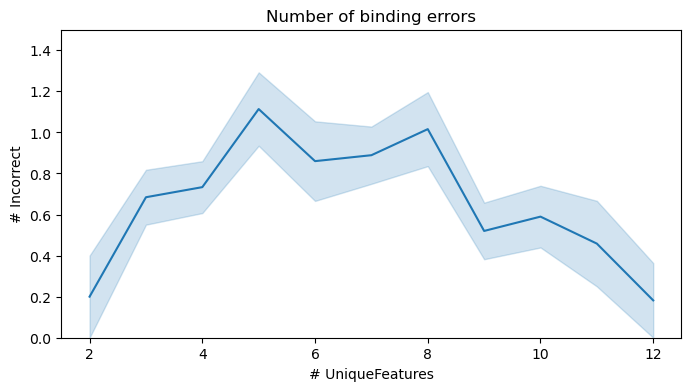

In [44]:
# plot error rates with SEM error bars
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.lineplot(x='nFeatures', y='nDiff', data=test, errorbar='se')
plt.xlabel('# UniqueFeatures')
plt.ylabel('# Incorrect')
plt.title('Number of binding errors')
plt.ylim(0,1.5)

In [36]:
i = 1
row = test[test.nDiff>2].iloc[i]
print(f'nErrors: {row.nDiff}')
for obj in row.features:
    print(obj)
print('\n')
print(row.response)
print('\n')
print(row.answer)


nErrors: 3.0
{'shape': 'pentagon', 'color': 'gold'}
{'shape': 'star', 'color': 'purple'}
{'shape': 'triangle', 'color': 'black'}
{'shape': 'umbrella', 'color': 'red'}
{'shape': 'down-arrow', 'color': 'black'}
{'shape': 'down-arrow', 'color': 'gold'}


The image contains five simple objects. 

Starting from the top left and moving right:
- A black triangle
- A gold down arrow
- A purple star
- A red umbrella
- A saddlebrown pentagon


[
    {
      "shape": "triangle",
      "color": "black"
    },
    {
      "shape": "down-arrow",
      "color": "gold"
    },
    {
      "shape": "star",
      "color": "purple"
    },
    {
      "shape": "umbrella",
      "color": "red"
    },
    {
      "shape": "pentagon",
      "color": "saddlebrown"
    }
]


[{'shape': 'down-arrow', 'color': 'green'}, {'shape': 'heart', 'color': 'red'}, {'shape': 'cross', 'color': 'gray'}, {'shape': 'heart', 'color': 'gold'}, {'shape': 'down-arrow', 'color': 'saddlebrown'}, {'shape': 'heart', 'color': 'saddlebrown'}]


In [141]:
import pandas as pd

search_path = '/Users/ic0523/Documents/projects/misc/vlm-binding/output/letters_search.csv'
test = pd.read_csv(search_path)
test['incongruent'] = test.incongruent.astype(bool)
test['answer'] = test.answer.values == 'True'
test['correct'] = test.answer == test.incongruent

(0.5, 1.0)

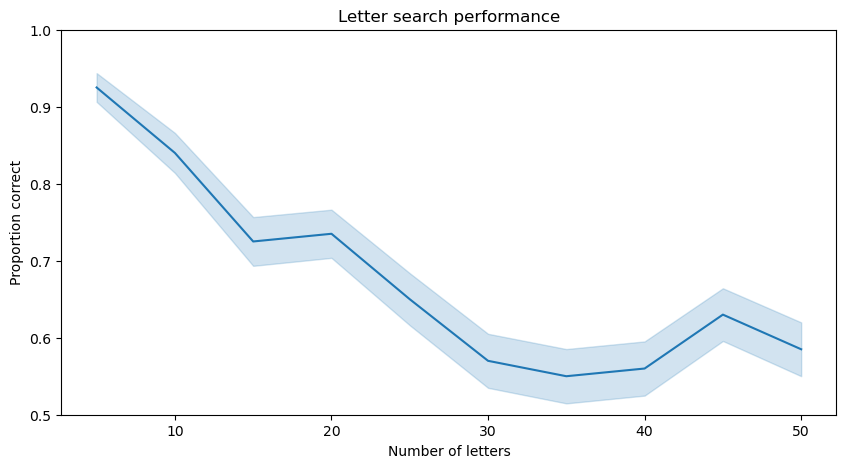

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot with error bars
plt.figure(figsize=(10, 5))
sns.lineplot(x='n_shapes', y='correct', data=test, errorbar='se')
plt.xlabel('Number of letters')
plt.ylabel('Proportion correct')
plt.title('Letter search performance')
plt.ylim(0.5,1)
#plt.plot(test.groupby('n_shapes').correct.mean())

In [21]:
from itertools import product

a = list(product(range(1,7), range(1,7)))
print(a)
len(a)

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]


36